# Exercise 3

In this assignment, you will find numerical solutions to the diffusion equation. In particular, you will use an implicit method, and consider problems with both Dirichlet and Neumann boundary conditions.

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

## Problem Overview

The 1D diffusion equation is :

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - Dirichlet Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a Dirichlet boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           \\
-\alpha   & 1+2\alpha & -\alpha   &           &           \\
          & -\alpha   & 1+2\alpha & -\alpha   &           \\
          &           & -\alpha   & 1+2\alpha & -\alpha   \\
          &           &           & -\alpha   & 1+2\alpha 
\end{pmatrix}$$

$$b = \begin{pmatrix}
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
\end{pmatrix}$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

First, write functions that will construct the matrix equation and boundary value term.

In [1]:
import unittest
import itertools
import numpy as np
import scipy.linalg as linalg
from time import perf_counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})


class Diffusion_Solution:
    boundary_types = ("Dirichelt", "Neumann")

    def __init__(
        self, s_type, x_n, x_step, t_n, t_step, k, spatial, u_initial, bounds
    ):
        """
        Data-class used to organise the objects required to implicitly 
        solve the diffusion equation
        
        Parameters
        ----------
        s_type : int
            The index of 'boundary_types' corresponding to the s_type of 
            boundary conditions used.
            0: 'Dirichlet'
            1: 'Neumann'
        x_n : int
            Number of spatial steps.
        x_step : float
            Size of each spatial step.
        t_n : int
            Number of temporal steps.
        t_step : float
            Size of each temporal step.
        k : float
            Thermal diffusivity.
        spatial : array_like
            Spatial coordinates of each step.
        u_initial : array_like
            Initial temperature dirstribution.
        bounds : array_like
            Initial boundary coniditions. 
        
        bound_type : str
            Type of boundary conditions used.
        bound_arr : array_like
            The boundary vector used to set fixed boundary conditions.
        matrix : array_like
            Diffusion matrix required to solve 1D diffusion equation.
        lu : LU_Decomposition
            LU decomposition of matrix required to solve the 1D diffusion
            equation using LU substitution.
        coords_current : array_like
            Current temperature distribution in 1D.
        """
        self.bound_type = self.boundary_types[s_type]
        self.x_n = x_n
        self.x_step = x_step
        self.t_n = t_n
        self.t_step = t_step
        self.k = k
        self.spatial = spatial
        self.u_initial = u_initial
        self.bounds = bounds
        self.bound_arr = None
        self.matrix = None
        self.lu = None
        self.coords_current = u_initial
        self.coords_all = None


class LU_Decomposition:
    """Data-class used to organise the LU decomposition of a square 
    matrix.

    Parameters
    ----------
    p : array-like
        Permutation matrix.
    l : array-like
        Lower triangular matrix with unit diagonal.
    u : array-like
        Upper triangular matrix.
    """
    def __init__(self, p, l, u):
        self.p = p
        self.l = l
        self.u = u


def create_dirichlet(x_n, x_step, t_step, k, bounds):
    """Creates matrix and boundary vector required to solve the 
    diffusion equation in 1D with Dirichlet boundary conditions.

    Parameters
    ----------
    x_n : int
        The number of spatial steps.
    x_step : float
        The size of each spatial step.
    t_step : float
        The size of each time step.
    k : float
        The thermal diffusivity.
    bounds : array_like
        The endpoint temperatures used to set Dirichlet boundary 
        conditions.

    Returns
    -------
    matrix: ndarray
        A two dimensional array containing the diffusion matrix
        required to solve the diffusion equation in 1D.
    bound_arr: ndarray
        The Dirichlet boundary vector.        
    """
    # Check that x_n contains at least two points
    if (x_n := int(x_n)) < 2:
        raise ValueError("at least two spacial step required")
    # Create the matrix
    alpha = k*t_step/np.square(x_step)
    matrix = np.identity(x_n, dtype=np.float64) * (1+2*alpha)
    np.fill_diagonal(matrix[1:, :-1], -alpha)
    np.fill_diagonal(matrix[:-1, 1:], -alpha)
    # Create the boundary vector
    bound_arr = np.zeros(x_n)
    bound_arr[0], bound_arr[-1] = bounds
    bound_arr *= -alpha
    return matrix, bound_arr


class Test_Create_Dirichlet(unittest.TestCase):
    """Testing of 'create_dirichlet'.
    """
    def setUp(self):
        """Initialize the required parameters to print the test results,
        and create arguments for 'create_dirichlet'.
        """
        self.print = False
        self.test_name = None
        self.result = "FAIL"
        self.output = ""
        self.x_n = 2
        self.x_step = 1
        self.t_step = 1
        self.k = 1
        self.bounds = (0, 1)
        self.matrix_out, self.bound_arr= create_dirichlet(
            self.x_n, self.x_step, self.t_step, self.k, self.bounds
        )

    def tearDown(self):
        """Print the test results to std.out.
        """
        if self.print is not False:
            print(f"{self.test_name}: {self.result}")
            for i in enumerate(self.test_name):
                print('-', end='')
            print(f"-\n{self.output}\n")

    def test_bad_x_n(self):
        """Test that the function throws correct error given a bad x_n.
        """
        # Error when x_n < 1.
        with self.assertRaises(ValueError):
            create_dirichlet(0, 1, 1, 1, (2, 2))
        # Error when x_n is not an integer.
        with self.assertRaises(ValueError):
            create_dirichlet('hello', 1, 1, 1, (2, 2))
    
    def test_matrix_out(self):
        """Checks that the output matrix has the expected form.
        """
        self.print = True
        self.test_name = "TEST OUTPUT MATRIX"
        matrix_true = np.array([[3, -1],[-1, 3]], dtype=float)
        equal = np.allclose(self.matrix_out, matrix_true)
        self.output = "True matrix\n\t"
        self.output += str(matrix_true).replace('\n', '\n\t')
        self.output += " \nCalculated matrix\n\t"
        self.output += str(self.matrix_out).replace('\n', '\n\t')
        # Run test and set result to 'SUCCESS' if it passes.
        self.assertTrue(np.allclose(self.matrix_out, matrix_true))
        self.result = "SUCCESS"

    def test_bound_arr(self):
        """Checks that the output boundary vector has the expected form.
        """
        self.print = True
        self.test_name = "TEST OUTPUT BOUNDARY VECTOR"
        alpha = self.k*self.t_step/np.square(self.x_step)
        vect_true = np.asarray(self.bounds)*(-alpha)
        self.output = f"True boundary vector\n\t{vect_true}\nCalculated "
        self.output = f"{self.output} boundary vector\n\t{self.bound_arr}"
        # Run test and set result to 'SUCCESS' if it passes.
        self.assertTrue(np.allclose(vect_true, self.bound_arr))
        self.result = "SUCCESS"

test_suite = unittest.makeSuite(Test_Create_Dirichlet)
runner = unittest.TextTestRunner(verbosity=0).run(test_suite)

----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


TEST OUTPUT BOUNDARY VECTOR: SUCCESS
----------------------------
True boundary vector
	[-0. -1.]
Calculated  boundary vector
	[-0. -1.]

TEST OUTPUT MATRIX: SUCCESS
-------------------
True matrix
	[[ 3. -1.]
	 [-1.  3.]] 
Calculated matrix
	[[ 3. -1.]
	 [-1.  3.]]



Now write a function which will transport the temperature distribution at time step $n$ to time step $n+1$. You will need to use an appropriate linear algebra routine.

In [2]:
def _get_LU(matrix):
    """LU decompose a matrix.
    
    Parameters
    ----------
    matrix : array-like
        Square matrix for LU decomposition.
    
    Returns
    -------
    lu_decomposition : LU_Decomposition
        The LU decomposition of 'matrix'.
    """
    return LU_Decomposition(*linalg.lu(matrix))


def _solve_LU(lu_decomp, b):
    """Solves the equation A*x = b using the LU decomposition of 
    A.
    
    Parameters
    ----------
    lu_decomp: LU_Decomposition
        The LU decomposition of A.
    b: array_like
    
    Returns
    -------
    x: array-like
    """
    y = linalg.solve(lu_decomp.p, b)
    z = linalg.solve_triangular(lu_decomp.l, y, lower=True)
    x = linalg.solve_triangular(lu_decomp.u, z)
    return x


def timestep_diffusion(
    u_current, bound_arr, t_n, matrix, method=0, VERBOSITY=0
):
    """Solve the diffusion equation for the next t_n timesteps.

    Paramters
    ---------
    u_current : array_like
        Current temperature distribution.
    bound_arr : array_like
        Boundary vector used to impose fixed boundary conditions.
    t_n : int
        The number of timesteps.
    matrix : array_like
        The diffusion matrix.
    method : int
        Index for method used to solve for next timestep:
        0: Invert matrix and use matrix multiplication 
        1: LU substitution
        2: scipy.linalg solve
    VERBOSITY : int
        Amount of information given at runtime
        0: No information
        1: Distance to completion

    Returns
    -------
    u_iterations : ndarray
        [t_n+1, N] array where N is the number of elements in u_current.
        The i^th subarray corresponds to the spatial distribution at 
        time i*t_n. Thus, i = 0 corresponds to u_current. 
    """
    # Check form of u_current.
    try:
        u_current = np.asarray(u_current)
        if u_current.ndim != 1:
            raise ValueError("u_current must be 1D")
    except Exception:                                                            
        u_type = u_current.__class__.__name__
        raise TypeError(f"{u_type} cannot be cast to ndarray")
    # Set up parameters for sol in time.
    u_iterations = np.zeros([t_n+1, len(u_current)], dtype=float)
    u_iterations[0] = u_current
    tenth = int(t_n/10)
    if tenth == 0:
        tenth = 1
    step = float(t_n/100)
    
    if method == 0:
        try:
            inverse = linalg.inv(matrix)
        except Exception:
            raise ValueError("unable to compute inverse from matrix")
        for i in range(t_n):
            if VERBOSITY == 1  and (i) % tenth == 0:
                print(f"{int(i/step)}% complete")
            u_iterations[i+1] = np.matmul(inverse, u_iterations[i]-bound_arr)
    
    elif method == 1:
        try:
            lu_decomp = _get_LU(matrix)          
        except Exception:
            raise ValueError("unable to compute LU decomposition from matrix")
        for i in range(t_n):
            if VERBOSITY == 1 and (i) % tenth == 0:
                print(f"{int(i/step)}% complete")
            u_iterations[i+1] = _solve_LU(lu_decomp, u_iterations[i]-bound_arr)
        
    elif method == 2:
        for i in range(t_n):
            if VERBOSITY == 1 and (i) % tenth == 0:
                print(f"{int(i/step)}% complete")
            u_iterations[i+1] = linalg.solve(matrix, u_iterations[i]-bound_arr)

    else:
        raise ValueError("'method' must be an element of the set {0, 1, 2}")
    
    if VERBOSITY == 1:
        print("100% complete")
    return u_iterations


class Test_get_LU(unittest.TestCase):
    def test_output(self):
        """Test that the _get_LU function returns a LU_Decomposition 
        object which recombines into the original matrix
        """
        matrix_true = np.array([[4, 3], [6, 3]])
        lu_out = _get_LU(matrix_true)
        matrix_out = np.matmul(lu_out.l, lu_out.u)
        matrix_out = np.matmul(lu_out.p, matrix_out)
        self.assertTrue(np.allclose(matrix_out, matrix_true))
        self.assertIsInstance(lu_out, LU_Decomposition)


class Test_Solve_LU(unittest.TestCase):  
    def test_unique_output(self):
        """Test behaviour when matrix equation 'M*x = b' has a unique
        sol.
        """
        m = np.array([[1, 1, 2], [1, 1, 1], [0, 1, 1]], dtype=float)
        b = np.array([3, 2, 1], dtype=float)
        x_true = linalg.solve(m, b)
        lu_decomp = _get_LU(m)
        x_out = _solve_LU(lu_decomp, b)
        self.assertTrue(np.allclose(x_true, x_out))
        self.result = "SUCCESS"

class Test_Timestep_Diffusion(unittest.TestCase):
    """Test 'timestep_diffusion' to ensure it produces the correct
    spatial solutions for all inputs.
    """
    def setUp(self):
        self.sol = Diffusion_Solution(
            0, 3, 1, 1, 1, 1, (0, 1), (1, 1), (0,2)
        )
        self.sol.bound_arr
        self.sol.coords_current = np.ones(self.sol.x_n, dtype=float)
        self.sol.matrix, self.sol.bound_arr = create_dirichlet(
            self.sol.x_n,
            self.sol.x_step,
            self.sol.t_step,
            self.sol.k,
            self.sol.bounds
        )
        self.sol.lu = _get_LU(self.sol.matrix)
        timestep = linalg.solve(self.sol.matrix,
                self.sol.coords_current - self.sol.bound_arr
        )
        self.coords_true = np.concatenate(
            [self.sol.coords_current, timestep]
        ).reshape(2, 3)

    def test_matrix(self):
        """Test output when solving via matrix inversion.
        """
        coords_out = timestep_diffusion(
            self.sol.coords_current,
            self.sol.bound_arr,
            self.sol.t_n,
            self.sol.matrix
        )
        self.assertTrue(np.allclose(self.coords_true, coords_out))

    def test_lu_decomp(self):
        """Test output when solving via LU decomposition.
        """
        self.sol.coords_all = timestep_diffusion(
            self.sol.coords_current,
            self.sol.bound_arr,
            self.sol.t_n,
            self.sol.matrix,
            method=1
        )
        self.assertTrue(
            np.allclose(self.coords_true, self.sol.coords_all)
        )


loader = unittest.TestLoader()
test_suite = unittest.TestSuite()
test_suite.addTest(unittest.makeSuite(Test_get_LU))
test_suite.addTest(unittest.makeSuite(Test_Solve_LU))
test_suite.addTest(unittest.makeSuite(Test_Timestep_Diffusion))
runner = unittest.TextTestRunner(verbosity=1).run(test_suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using an appropriate plotting routine.

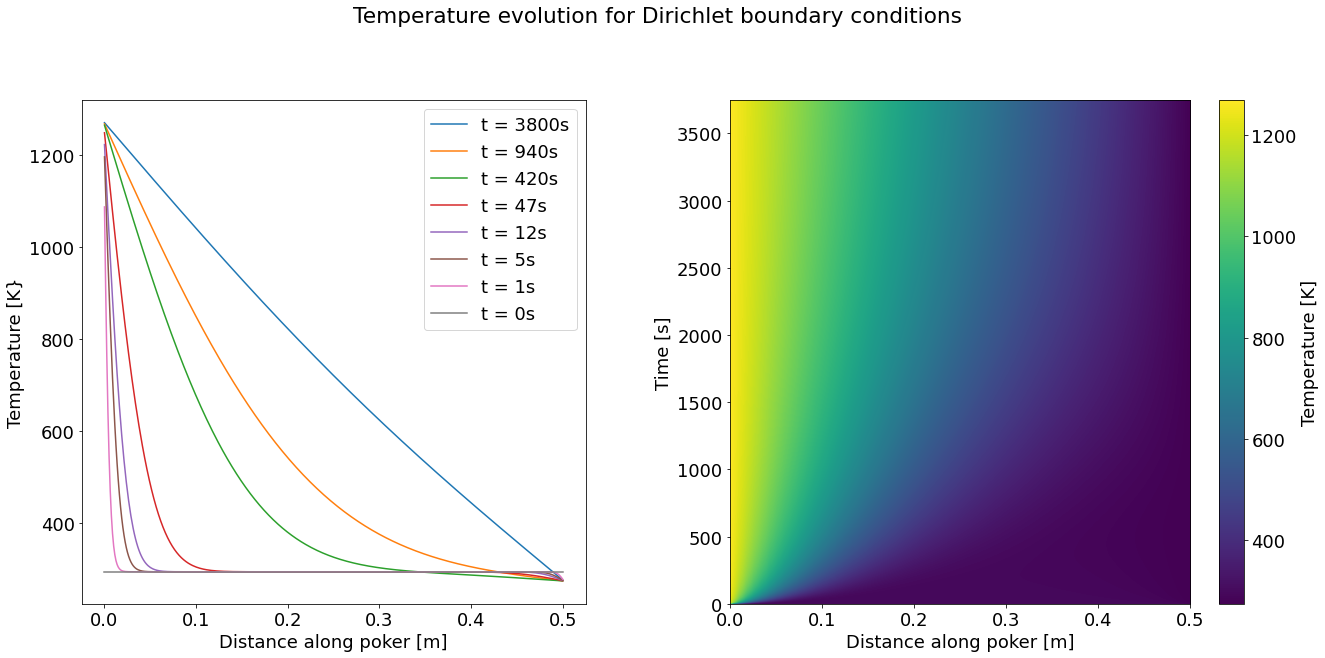

In [3]:
# Initial conditions
temp_0 = 293.15
dir_x_n = 400
dir_x_step = 0.5/dir_x_n

sol_dir = Diffusion_Solution(
    0,
    dir_x_n,
    dir_x_step,
    t_n=15000,
    t_step=0.25,
    k=59/(7900*450),
    spatial=np.linspace(0, dir_x_n*dir_x_step, dir_x_n),
    u_initial=np.full(dir_x_n, temp_0, dtype=float),
    bounds=(1273.15, 273.15)
)

sol_dir.matrix, sol_dir.bound_arr = create_dirichlet(
    sol_dir.x_n, sol_dir.x_step, sol_dir.t_step, sol_dir.k, sol_dir.bounds
)
sol_dir.coords_all = timestep_diffusion(
    sol_dir.coords_current,
    sol_dir.bound_arr,
    sol_dir.t_n,
    sol_dir.matrix,
)


# determine points to graph
dir_time_id = [[int(sol_dir.t_n/i**2) for i in range(1, 4)], [int(sol_dir.t_n/80/i**2) for i in range(1, 4)]]
dir_time_id = list(itertools.chain.from_iterable(dir_time_id))
dir_time_id.extend([4, 0])

# graphing
fig_dir = plt.figure(figsize=[20, 10])
fig_dir.suptitle("Temperature evolution for Dirichlet boundary conditions")
axes_graph = fig_dir.add_axes([0.1, 0.15, 0.35, 0.7])
axes_graph.set(xlabel="Distance along poker [m]", ylabel="Temperature [K}")
for id, x in enumerate(dir_time_id):
    axes_graph.plot(
        sol_dir.spatial, 
        sol_dir.coords_all[x],
        label="t = {:g}s".format(float(f'{x*sol_dir.t_step:.2g}'))
    )
axes_graph.legend()
axes_imshow = fig_dir.add_axes([0.55, 0.15, 0.4, 0.7])
axes_imshow.set(xlabel="Distance along poker [m]", ylabel="Time [s]")
im = axes_imshow.imshow(
    sol_dir.coords_all[::-1],
    aspect='auto',
    extent=[0, 0.5, 0, sol_dir.t_n*sol_dir.t_step]
)
cbar = plt.colorbar(im, ax=axes_imshow)
cbar.set_label("Temperature [K]")
plt.show()

Drag racing different methods of solving the implicit equation $ u^N = Mu^{n+1} + b $.

In this section three different techniques will be investigated to compare their relative speed:
 - Matrix inversion
 - LU substitution
 - Solving general scipy.solve

In each the case the heat equation will be solved with Dirichlet boundary conditions. The number of time steps will be varied between 1 and 100 to and the size of each step will be kept constant.

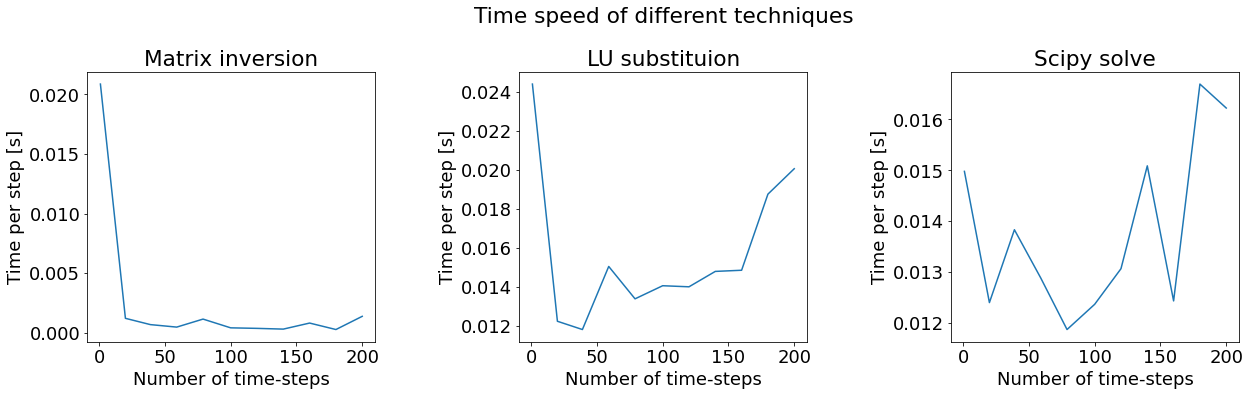

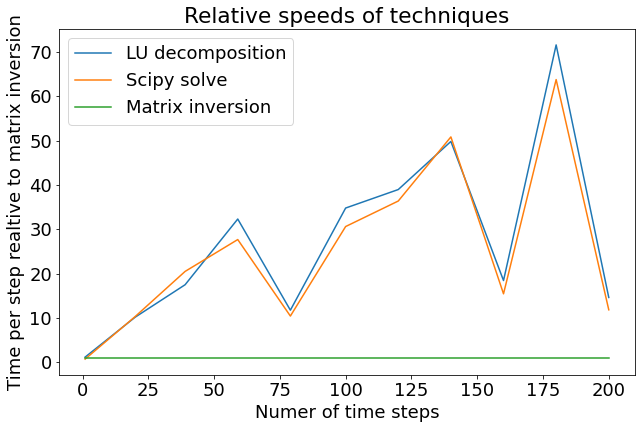

In [41]:
max_runs = 200 # NOTE: reduce this and run again if cell takes too long


# run timestep dirichlet for the different timesteps and record the time taken
# 0: matrix inversion, 1: LU substitution, 2: scipy.solve
techniques = [np.zeros(11, dtype=float) for i in range(3)]
technique_names = ("Matrix inversion", "LU substituion", "Scipy solve")
n_runs = [int(max_runs*i) for i in np.linspace(1, 0.1, 10)]
n_runs.append(1)

for technique_id, technique in enumerate(techniques):
    for id, run in enumerate(n_runs):
        time_0 = perf_counter()
        timestep_diffusion(
            sol_dir.coords_current, sol_dir.bound_arr, run, sol_dir.matrix, method=technique_id
        )
        time_1 = perf_counter()
        technique[id] = (time_1-time_0)/run

tech_fig = plt.figure(figsize=[20, 5])
tech_fig.suptitle("Time speed of different techniques")
ax1 = tech_fig.add_axes([0.1, 0.05, 0.2, 0.75])
ax2 = tech_fig.add_axes([0.4, 0.05, 0.2, 0.75])
ax3 = tech_fig.add_axes([0.7, 0.05, 0.2, 0.75])
axes = (ax1, ax2, ax3)
for id, axis in enumerate(axes):
    axis.plot(n_runs, techniques[id])
    axis.set(
        title=technique_names[id],
        xlabel="Number of time-steps",
        ylabel="Time per step [s]"
    )
plt.show()

LU_rel = techniques[1]/techniques[0]    
solve_rel = techniques[2]/techniques[0]

rel_fig = plt.figure(figsize=[10, 6])
rel_ax = rel_fig.add_axes([0.1, 0.1, 0.8, 0.8])
rel_ax.plot(n_runs, LU_rel, label="LU decomposition")
rel_ax.plot(n_runs, solve_rel, label="Scipy solve")
rel_ax.plot(n_runs, [1 for i in range(11)], label="Matrix inversion")
rel_ax.set(
    title="Relative speeds of techniques",
    xlabel="Numer of time steps",
    ylabel="Time per step realtive to matrix inversion"
)
# rel_ax.set_yscale("log")
rel_ax.legend()

plt.show()

## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two noces have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
\end{pmatrix}$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

First write any new functions you need. You should be able to re-use some functions from Part 1.

In [5]:
def create_neumann(x_n, x_step, t_step, k, bound):
    """Creates matrix and boundary vector required to solve the 
    diffusion equation in 1D with Neumann boundary conditions.

    Parameters
    ----------
    x_n : int
        The number of spatial steps.
    x_step : float
        The size of each spatial step.
    t_step : float
        The size of each time step.
    k : float
        The thermal diffusivity.
    bound : float
        The fixed boundary temperature.

    Returns
    -------
    matrix : ndarray
        A two dimensional array containing the diffusion matrix
        required to solve the diffusion equation in 1D.
    bound_arr : ndarray
        The Dirichlet boundary vector.        
    """
    # Create the marix M
    # Check that x_n is of the correct form
    if (x_n := int(x_n)) < 2:
        raise ValueError("at least two spacial steps required")
    alpha = k*t_step/np.square(x_step)
    matrix = np.identity(x_n, dtype=np.float64) * (1+2*alpha)
    np.fill_diagonal(matrix[1:, :-1], -alpha)
    np.fill_diagonal(matrix[:-1, 1:], -alpha)
    matrix[x_n-1, x_n-1] = 1+alpha

    # Create the boundary vector
    bound_arr = np.zeros(x_n)
    bound_arr[0] = (-alpha)*bound
    return matrix, bound_arr

Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using a sensible plotting function.

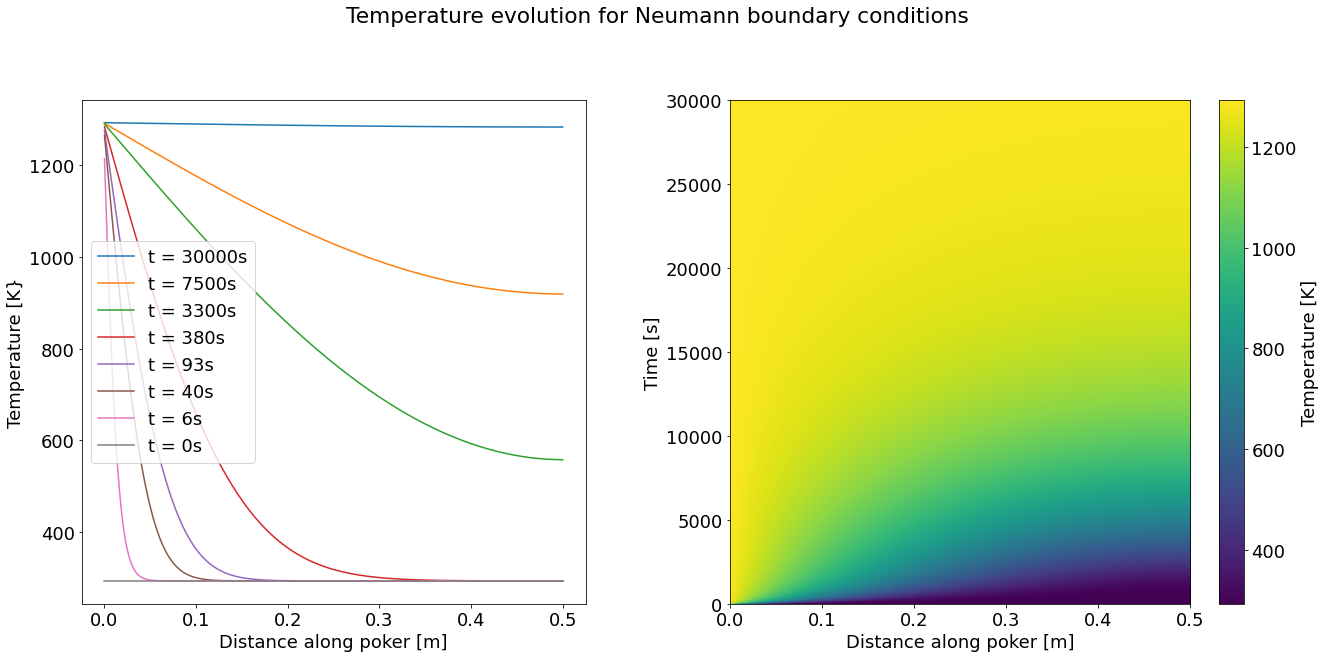

In [6]:
neu_x_n = 400
neu_x_step = 0.5/neu_x_n

sol_neu = Diffusion_Solution(
    0,
    neu_x_n,
    neu_x_step,
    t_n=20000,
    t_step=1.5,
    k=59/(7900*450),
    spatial=np.linspace(0, neu_x_n*neu_x_step, neu_x_n),
    u_initial=np.full(neu_x_n, temp_0, dtype=float),
    bounds=temp_0+1000
)
sol_neu.matrix, sol_neu.bound_arr = create_neumann(
    sol_neu.x_n, sol_neu.x_step, sol_neu.t_step, sol_neu.k, sol_neu.bounds
)
sol_neu.coords_all = timestep_diffusion(
    sol_neu.coords_current,
    sol_neu.bound_arr,
    sol_neu.t_n,
    sol_neu.matrix
)

# determine points to graph
neu_time_id = [[int(sol_neu.t_n/i**2) for i in range(1, 4)],
    [int(sol_neu.t_n/80/i**2) for i in range(1, 4)]]
neu_time_id = list(itertools.chain.from_iterable(neu_time_id))
neu_time_id.extend([4, 0])

# graphing
fig_neu = plt.figure(figsize=[20, 10])
fig_neu.suptitle("Temperature evolution for Neumann boundary conditions")
axes_graph = fig_neu.add_axes([0.1, 0.15, 0.35, 0.7])
axes_graph.set(xlabel="Distance along poker [m]", ylabel="Temperature [K}")
for id, x in enumerate(neu_time_id):
    axes_graph.plot(
        sol_neu.spatial, 
        sol_neu.coords_all[x],
        label="t = {:g}s".format(float(f'{x*sol_neu.t_step:.2g}'))
    )
axes_graph.legend()
axes_imshow = fig_neu.add_axes([0.55, 0.15, 0.4, 0.7])
axes_imshow.set(xlabel="Distance along poker [m]", ylabel="Time [s]")
im = axes_imshow.imshow(
    sol_neu.coords_all[::-1],
    aspect='auto',
    extent=[0, 0.5, 0, sol_neu.t_n*sol_neu.t_step]
)
cbar = plt.colorbar(im, ax=axes_imshow)
cbar.set_label("Temperature [K]")
plt.show()

# Part 3

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.

The program solve the 1D diffusion equation for a 50cm rod using Dirichlet and Neumann boundary conditions. In both cases the rod is initially at 293K and then has one end put into a furnace at 1273K. In the Neumann case the other end of the rod is places into a ice bucket at 273K, while it does not lose any heat in the Dirichlet case.

The diffusion equation is solved implicitly by making use of the Taylor expansion of the first and second derivative which can be seen below:


Three different methods of solving the implicit equation $Mu^{n+1} + b = u^n$ are investigated: matrix inversion, LU decomposition, and scipy.solve. 

From the speed tests it is clear that LU decomposition and scipy.solve are roughly equal in terms of speed. This was unexpected as the LU decomposition takes advantage of the fact that the matrix remains unchanged for subsequent time-steps and thus only has to decompose it once, while the scipy.solve method would have to recalculate the relevant decomposition for each time-step. However, due to the design of the LU decomposition method it requires two calls to scipy.linalg.solve_triangular for each of the triangular matrices and a call to scipy.linalg.solve for the permutation matrix. These extra calls, especially to call scipy.linalg.solve may negate may of the speed gains. It also implies that the scipy.linalg.solve method might not distinguish between 'easy' and 'hard' matrix equations as the optimum number of steps to solve a permutation matrix equation is vastly fewer than a tridiagonal matrix equation.

It is clear that the inverse matrix method dominates the other two for more than $\sim$ 5 time-steps. This is also counter intuitive as matrix inversion is more costly than LU decomposition. However, it also benefits from the fact that the matrix does not change between time-steps. Furthermore, it only requires one call to np.matmul for matrix multiplication and thus does not suffer from the same issues as the LU decomposition. At more than $\sim$ 25 timesteps it is at least 10 times faster than the other two methods, and sometimes measures as high as 70 times faster.

Thus, matrix inversion was used for all graphing applications.

NOTE: The maximum number of time-steps used in these trials was 200, however this has been reduced to allow adequate run-times on worse hardware, to reproduce this please change the value of max_runs to 200 in the relevant cell.

The dirichlet boundary conditions converge on a linear temperature distribution between the two ends of the rod, while the Neumann conditions converge on a constant temperature throughout the entire rod. It is interesting to note that the Neumann case required almost 10 times as long to converge to final state. This may be understood as the entire rod is being heated to 1273K meaning that the rod has a much higher internal energy than the Dirichlet case. Furthermore, as the rod heats up in the Neumann case it reaches a point where the temperature gradient in the rod starts to diminish. Thus, it would take longer heat will flow at a slower rate, further increasing the time required to fully heat the final.


<!--
*Taylor series expansion to approximate second derivative of function*

$$ f(a+x) = \sum_{i=0}^{\infty}{\frac{f^i(a)x^i}{i!}} \approx f(a) + xf'(a) + \frac{1}{2}x^2f''(a)$$
$$ f(a-x) = \sum_{i=0}^{\infty}{\frac{(-1)^if^i(a)x^i}{i!}} \approx f(a) -xf'(a) + \frac{1}{2}x^2f(a)$$
$$ \Rightarrow f(a+x) + f(a-x) \approx f(a) + xf'(a) + \frac{1}{2}x^2f''(a) + f(a) -xf'(a) + \frac{1}{2}x^2f(a)$$
$$ \Rightarrow f''(a) \approx f(a+x) + f(a-x) -2f(a)$$


Probably want to use successive over relaxation (SOR) method as this requires $ \sim \frac{1}{3}J $ iterations to converge compared to the $ \sim \frac{1}{2}J^2 $ interations required for the Jacobi and $ \sim \frac{1}{4} J^2 $ required for the Gauss-Seidel method.
The SOR method is given by the following equation(s):

$$ V'_{i,j} = V_{i,j} = \omega\left(\frac{V'_{i-1,j} + V_{i+1,j} + V'_{i,j-1}}{4} - (\mathrm{RH side}) - V_{i,j} \right) $$


Note that one requires $\omega \in (0, 2)$ for SOR to converge (see Numerical Recipes 3rd edition, chapter 20.5.1, page 1062)

*Crank-Nicholson method is a good way to model evolution in time*

Note: when using the implicit method one is evaluating $u_{t+1}$ through the relation:
$$ M^{-1}(u_{t+0} - b_t) = u_{t+1} $$


Thing to note:
Usually would write unittesting in a separate file however due to the way this task has been constructed this is obviously not possible.

Characteristic time is given by T = L^2/k (see: Baierlein, R. (1999) Thermal Physics, Cambridge, Cambridge University Press., pages 371-373)s.t. completion percentage is F(t)=F(0)*(1-e^(-t/T))
Characteristic time: 15064s

Note solving for the inverse and then using it to compute the next steps is vastly faster than any other solution
    - may also use LU decomposition but solving for the different arrays takes longer than matrix multiplication
    - may also solve directly but this is very slow in python
    -->
